In [2]:
import pandas as pd
import numpy as np
from statsbombpy import sb
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from scipy.ndimage import gaussian_filter


In [3]:
free_comps = sb.competitions()

In [4]:
free_comps.columns

Index(['competition_id', 'season_id', 'country_name', 'competition_name',
       'competition_gender', 'competition_youth', 'competition_international',
       'season_name', 'match_updated', 'match_updated_360',
       'match_available_360', 'match_available'],
      dtype='object')

In [5]:
mls_matches = sb.matches(competition_id = 44, season_id = 107)

In [6]:
mls_matches.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3877060,2023-08-27,02:39:00.000,United States of America - Major League Soccer,2023,New York Red Bulls,Inter Miami,0,2,available,...,2023-11-22T12:46:54.939710,28,Regular Season,Red Bull Arena (New Jersey),Allen Chapman,Troy Lesesne,Gerardo Daniel Martino,1.1.0,2,2
1,3877090,2023-09-04,05:09:00.000,United States of America - Major League Soccer,2023,LAFC,Inter Miami,1,3,available,...,2023-11-19T14:27:32.827119,30,Regular Season,BMO Stadium,Ted Unkel,Steven Cherundolo,Gerardo Daniel Martino,1.1.0,2,2
2,3877194,2023-10-22,01:09:00.000,United States of America - Major League Soccer,2023,Charlotte,Inter Miami,1,0,available,...,2023-12-06T08:48:24.034035,38,Regular Season,Bank of America Stadium,Guido Gonzalez,Christian Lattanzio,Gerardo Daniel Martino,1.1.0,2,2
3,3877072,2023-08-31,02:39:00.000,United States of America - Major League Soccer,2023,Inter Miami,Nashville SC,0,0,available,...,2023-11-22T13:12:22.161272,29,Regular Season,DRV PNK Stadium,Chris Penso,Gerardo Daniel Martino,Gary Smith,1.1.0,2,2
4,3877170,2023-10-08,02:39:00.000,United States of America - Major League Soccer,2023,Inter Miami,Cincinnati,0,1,available,...,2023-11-21T13:46:52.693519,37,Regular Season,DRV PNK Stadium,Rubiel Vazquez,Gerardo Daniel Martino,Pat Noonan,1.1.0,2,2


In [7]:
mls_matches['home_team'].values

array(['New York Red Bulls', 'LAFC', 'Charlotte', 'Inter Miami',
       'Inter Miami', 'Inter Miami'], dtype=object)

In [8]:
mls_matches[mls_matches['home_team'] == 'LAFC']

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
1,3877090,2023-09-04,05:09:00.000,United States of America - Major League Soccer,2023,LAFC,Inter Miami,1,3,available,...,2023-11-19T14:27:32.827119,30,Regular Season,BMO Stadium,Ted Unkel,Steven Cherundolo,Gerardo Daniel Martino,1.1.0,2,2


In [9]:
mls_dallas = mls_matches

In [10]:
events_df = sb.events(match_id = 3877090)

In [11]:
for k in events_df.columns:
    print(k)

50_50
bad_behaviour_card
ball_receipt_outcome
ball_recovery_recovery_failure
block_offensive
carry_end_location
clearance_aerial_won
clearance_body_part
clearance_head
clearance_left_foot
clearance_right_foot
counterpress
dribble_no_touch
dribble_nutmeg
dribble_outcome
dribble_overrun
duel_outcome
duel_type
duration
foul_committed_advantage
foul_committed_card
foul_won_advantage
foul_won_defensive
goalkeeper_body_part
goalkeeper_end_location
goalkeeper_outcome
goalkeeper_position
goalkeeper_technique
goalkeeper_type
id
index
injury_stoppage_in_chain
interception_outcome
location
match_id
minute
off_camera
out
pass_aerial_won
pass_angle
pass_assisted_shot_id
pass_body_part
pass_cross
pass_cut_back
pass_end_location
pass_goal_assist
pass_height
pass_inswinging
pass_length
pass_miscommunication
pass_no_touch
pass_outcome
pass_recipient
pass_recipient_id
pass_shot_assist
pass_switch
pass_technique
pass_through_ball
pass_type
period
play_pattern
player
player_id
position
possession
possessi

In [12]:
events_df.play_pattern.value_counts()

play_pattern
Regular Play      1540
From Throw In      659
From Free Kick     582
From Goal Kick     227
From Keeper        147
From Kick Off      106
From Corner         96
From Counter        36
Other                2
Name: count, dtype: int64

In [13]:
df = events_df[['team' ,'minute','player', 'location', 'carry_end_location','pass_end_location','play_pattern','pass_type', 'pass_shot_assist','pass_goal_assist','under_pressure','pass_through_ball','pass_cross','pass_cut_back','carry_end_location','shot_statsbomb_xg']]

In [14]:
df_shot = events_df[['team' ,'minute','player', 'location','shot_end_location', 'shot_one_on_one','shot_outcome']]

In [15]:
df.head()

,team,minute,player,location,carry_end_location,pass_end_location,play_pattern,pass_type,pass_shot_assist,pass_goal_assist,under_pressure,pass_through_ball,pass_cross,pass_cut_back,carry_end_location,shot_statsbomb_xg
0,LAFC,0,NaN,NaN,NaN,NaN,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Inter Miami,0,NaN,NaN,NaN,NaN,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LAFC,0,NaN,NaN,NaN,NaN,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Inter Miami,0,NaN,NaN,NaN,NaN,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LAFC,45,NaN,NaN,NaN,NaN,From Free Kick,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_cross = df[(df['team'] == 'LAFC') & (df['pass_cross'] == True)]

In [17]:
df_cross['xstart'] = df_cross['location'].str[0]
df_cross['ystart'] = df_cross['location'].str[1]
df_cross['xend'] = df_cross['pass_end_location'].str[0]
df_cross['yend'] = df_cross['pass_end_location'].str[1]

/var/folders/85/d_fv83j92kq22pp6q4hcdzmh0000gp/T/ipykernel_71093/319249429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cross['xstart'] = df_cross['location'].str[0]
/var/folders/85/d_fv83j92kq22pp6q4hcdzmh0000gp/T/ipykernel_71093/319249429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cross['ystart'] = df_cross['location'].str[1]
/var/folders/85/d_fv83j92kq22pp6q4hcdzmh0000gp/T/ipykernel_71093/319249429.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [18]:
df_cross.head()

,team,minute,player,location,carry_end_location,pass_end_location,play_pattern,pass_type,pass_shot_assist,pass_goal_assist,under_pressure,pass_through_ball,pass_cross,pass_cut_back,carry_end_location,shot_statsbomb_xg,xstart,ystart,xend,yend
66,LAFC,4,Denis Bouanga,"[111.3, 12.4]",NaN,"[112.7, 40.3]",Regular Play,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,111.3,12.4,112.7,40.3
69,LAFC,5,Carlos Alberto Vela Garrido,"[112.5, 73.9]",NaN,"[108.6, 27.1]",From Corner,Recovery,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,112.5,73.9,108.6,27.1
316,LAFC,27,Sergi Palencia Hurtado,"[98.0, 68.9]",NaN,"[109.5, 35.9]",Regular Play,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,98.0,68.9,109.5,35.9
324,LAFC,27,Giorgio Chiellini,"[89.2, 4.0]",NaN,"[111.9, 76.8]",Regular Play,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,89.2,4.0,111.9,76.8
528,LAFC,47,Denis Bouanga,"[109.6, 13.1]",NaN,"[111.9, 36.5]",Regular Play,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,109.6,13.1,111.9,36.5


In [19]:
df_cross['play_pattern'].value_counts()

play_pattern
Regular Play      6
From Free Kick    3
From Corner       1
From Goal Kick    1
From Counter      1
From Keeper       1
From Throw In     1
Name: count, dtype: int64

In [20]:
pitch = Pitch(pitch_type='statsbomb')

### Plot for crosses, crosses that led to a shot (green), and cross under pressure (orange)

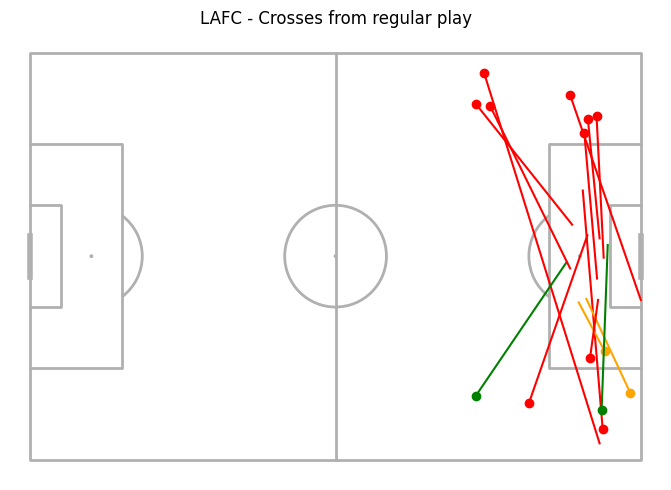

In [21]:
fig, ax = pitch.draw(figsize=(8,5))

for i in range(len(df_cross)):
    row = df_cross.iloc[i]
    if row['pass_shot_assist'] == True:
        color = 'green'
    elif row['under_pressure'] == True:
        color = 'orange'
    else:
        color = 'red'
    
    ax.plot([row['xstart'], row['xend']], [row['ystart'], row['yend']], color=color)
    ax.plot(row['xstart'], row['ystart'], 'o', color=color)

ax.set_title('LAFC - Crosses from regular play')
plt.show()

In [22]:
df_shot['xstart'] = df_shot['location'].str[0]
df_shot['ystart'] = df_shot['location'].str[1]
df_shot['xend'] = df_shot['shot_end_location'].str[0]
df_shot['yend'] = df_shot['shot_end_location'].str[1]

/var/folders/85/d_fv83j92kq22pp6q4hcdzmh0000gp/T/ipykernel_71093/2131087252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shot['xstart'] = df_shot['location'].str[0]
/var/folders/85/d_fv83j92kq22pp6q4hcdzmh0000gp/T/ipykernel_71093/2131087252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shot['ystart'] = df_shot['location'].str[1]
/var/folders/85/d_fv83j92kq22pp6q4hcdzmh0000gp/T/ipykernel_71093/2131087252.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

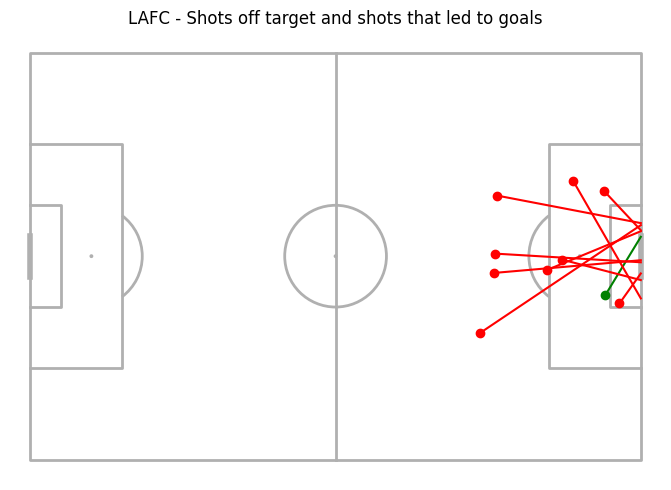

In [23]:
fig, ax = pitch.draw(figsize=(8,5))

#Shots on goal
shots = df_shot[(df_shot['team'] == 'LAFC') & (df_shot['shot_outcome'] == 'Goal')]
ax.plot((shots.xstart, shots.xend),(shots.ystart, shots.yend),color = 'green')
ax.plot(shots.xstart, shots.ystart, 'o', color = 'green')

#Shots off target
shots_ot = df_shot[(df_shot['team'] == 'LAFC') & (df_shot['shot_outcome'] == 'Off T')]
ax.plot((shots_ot.xstart, shots_ot.xend),(shots_ot.ystart, shots_ot.yend),color = 'red')
ax.plot(shots_ot.xstart, shots_ot.ystart, 'o', color = 'red')

ax.set_title("LAFC - Shots off target and shots that led to goals")
plt.show()


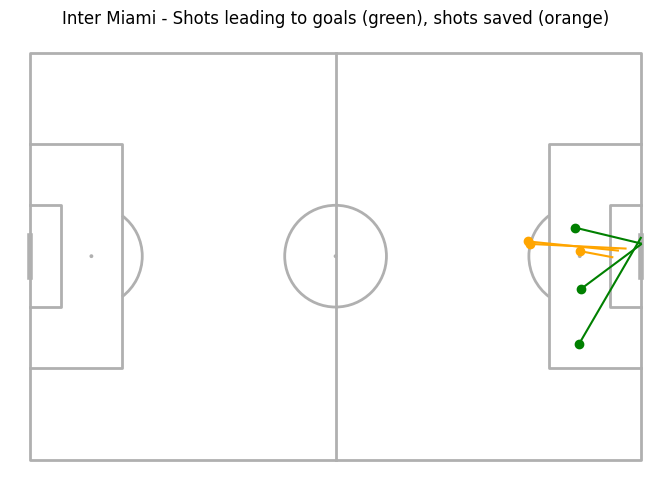

In [24]:
fig, ax = pitch.draw(figsize=(8,5))

#Shots on goal
shots = df_shot[(df_shot['team'] == 'Inter Miami') & (df_shot['shot_outcome'] == 'Goal')]
ax.plot((shots.xstart, shots.xend),(shots.ystart, shots.yend),color = 'green')
ax.plot(shots.xstart, shots.ystart, 'o', color = 'green')

#Shots off target
shots_ot = df_shot[(df_shot['team'] == 'Inter Miami') & (df_shot['shot_outcome'] == 'Saved')]
ax.plot((shots_ot.xstart, shots_ot.xend),(shots_ot.ystart, shots_ot.yend),color = 'orange')
ax.plot(shots_ot.xstart, shots_ot.ystart, 'o', color = 'orange')

ax.set_title("Inter Miami - Shots leading to goals (green), shots saved (orange)")
plt.show()


In [25]:
###Heat map of pressure events

In [26]:
pressure_events = events_df[['team' ,'minute','player', 'location','shot_end_location', 'shot_one_on_one','shot_outcome','pass_outcome', 'under_pressure']]

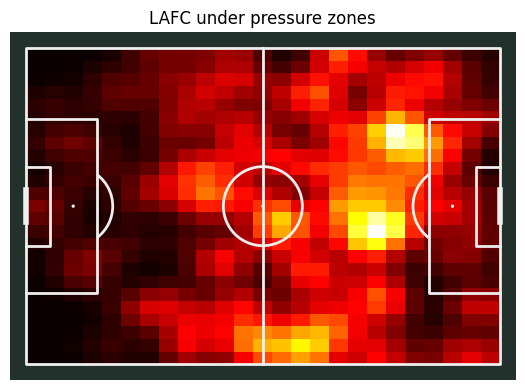

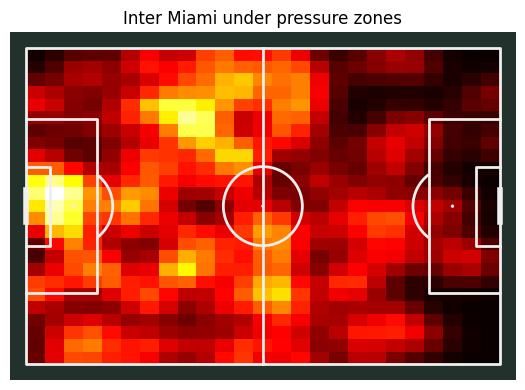

In [27]:
for Team in events_df['team'].unique():
    pressure_events = events_df[(events_df['team'] == Team) & (events_df['under_pressure'] == True)]
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#efefef', line_zorder=3)
    fig, ax = pitch.draw(figsize=(8, 4))
    bin_stat = pitch.bin_statistic(pressure_events['location'].str[0], pressure_events['location'].str[1], statistic='count', bins = (25,25))
    bin_stat['statistic'] = gaussian_filter(bin_stat['statistic'],1)
    pcm = pitch.heatmap(bin_stat, ax = ax, cmap = 'hot')
    ax.set_title(f'{Team} under pressure zones')
plt.show()